In [17]:
import numpy as np
import pandas as pd
import librosa
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import os
import matplotlib.pyplot as plt

class AnimalAudioDetector:
    def __init__(self, sample_rate=22050, duration=5):
        """
        Initialize the animal audio detection system
        
        :param sample_rate: Audio sampling rate (default 22050 Hz)
        :param duration: Length of audio clips to process (default 5 seconds)
        """
        self.sample_rate = sample_rate
        self.duration = duration
        self.model = None
    
    def extract_features(self, path):
        y, sr = librosa.load(path, sr=self.sample_rate, duration=self.duration)
        mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
        return log_mel_spectrogram
    
    def prepare_dataset(self, audio_paths, labels): 
        features = []
        for path in audio_paths:
            feature = self.extract_features(path)
            features.append(feature)
        
        n_mels = features[0].shape[0]
        for feature in features:
            if feature.shape[0] != n_mels:
                raise ValueError("All features must have the same number of mel bands.")
        
        max_length = max([f.shape[1] for f in features])
        print(f"Maximum feature length: {max_length}")
        
        padded_features = []
        for feature in features:
            if feature.shape[1] < max_length:
                padded_feature = np.pad(feature, ((0, 0), (0, max_length - feature.shape[1])), mode='constant')
            else:
                padded_feature = feature[:, :max_length]
            padded_features.append(padded_feature)
        
        features = np.array(padded_features)
        features = features.reshape(-1, n_mels, max_length, 1)
        labels = np.array(labels)
        
        print(f"Features shape: {features.shape}")
        print(f"Labels shape: {labels.shape}")
        
        return features, labels 
    
    def build_model(self, input_shape, num_classes):
        self.model = Sequential([
            Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
            MaxPooling2D(pool_size=(2, 2)),
            Conv2D(64, kernel_size=(3, 3), activation='relu'),
            MaxPooling2D(pool_size=(2, 2)),
            Flatten(),
            Dense(128, activation='relu'),
            Dropout(0.5),
            Dense(num_classes, activation='softmax')
        ])
        
        self.model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        self.model.save('animal_audio_detector_model.h5')
        print("Model built and compiled.")
    
    def train(self, X_train, y_train, X_val=None, y_val=None, epochs=50, batch_size=32):
        if self.model is None:
            raise ValueError("Model must be built before training")
        
        history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val) if X_val is not None and y_val is not None else None,
            epochs=epochs,
            batch_size=batch_size
        )
        print("Training completed.")
        self.model.save_weights('audio_animal.weights.h5')
        return history
    
    def predict(self, audio_path):
        feature = self.extract_features(audio_path)
        feature = feature.reshape(1, feature.shape[0], feature.shape[1], 1)
        
        prediction = self.model.predict(feature)
        return np.argmax(prediction)
    
    def evaluate(self, X_test, y_test):
        loss, accuracy = self.model.evaluate(X_test, y_test)
        return accuracy * 100
    
    def save_model(self, weights_path='audio_animal.weights.h5', config_path='animal_audio_detector_config.pkl'):
        if self.model:
            self.model.save_weights(weights_path)
        with open(config_path, 'wb') as f:
            pickle.dump({
                'sample_rate': self.sample_rate,
                'duration': self.duration,
                'max_length': self.max_length
            }, f)

def main():
    train_folder = 'dataset\\DataTrain'
    test_folder = 'dataset\\DataTest'
    classes = ['cat', 'dog', 'duck', 'horse']
    
    def load_data(folder, classes):
        audio_paths = []
        labels = []
        for idx, animal_class in enumerate(classes):
            class_folder = os.path.join(folder, animal_class)
            if not os.path.isdir(class_folder):
                print(f"Warning: Directory '{class_folder}' does not exist.")
                continue
            for file_name in os.listdir(class_folder):
                if file_name.endswith('.wav'):
                    file_path = os.path.join(class_folder, file_name)
                    audio_paths.append(file_path)
                    label = [0] * len(classes)
                    label[idx] = 1
                    labels.append(label)
        return audio_paths, labels
    
    audio_paths_train, labels_train = load_data(train_folder, classes)
    print(f"Total training samples: {len(audio_paths_train)}")
    
    audio_paths_test, labels_test = load_data(test_folder, classes)
    print(f"Total testing samples: {len(audio_paths_test)}")
    
    detector = AnimalAudioDetector()
    
    X_train, y_train = detector.prepare_dataset(audio_paths_train, labels_train)
    
    X_test, y_test = detector.prepare_dataset(audio_paths_test, labels_test)
    
    print("Training label distribution:")
    print(np.sum(y_train, axis=0))
    print("Testing label distribution:")
    print(np.sum(y_test, axis=0))
    
    detector.build_model(
        input_shape=(X_train.shape[1], X_train.shape[2], 1),
        num_classes=len(classes)
    )
    detector.train(X_train, y_train)
    
    accuracy = detector.evaluate(X_test, y_test)
    print(f'Model accuracy on test set: {accuracy:.2f}%')
    
    # Plot training label distribution
    train_label_distribution = np.sum(y_train, axis=0)
    plt.figure(figsize=(10, 5))
    plt.bar(classes, train_label_distribution)
    plt.title('Training Label Distribution')
    plt.xlabel('Classes')
    plt.ylabel('Frequency')
    plt.show()

    # Plot testing label distribution
    test_label_distribution = np.sum(y_test, axis=0)
    plt.figure(figsize=(10, 5))
    plt.bar(classes, test_label_distribution)
    plt.title('Testing Label Distribution')
    plt.xlabel('Classes')
    plt.ylabel('Frequency')
    plt.show()


Total training samples: 10
Total testing samples: 11
Maximum feature length: 216
Features shape: (10, 128, 216, 1)
Labels shape: (10, 4)


Maximum feature length: 216
Features shape: (11, 128, 216, 1)
Labels shape: (11, 4)
Training label distribution:
[2 4 2 2]
Testing label distribution:
[3 3 2 3]
Model built and compiled.
Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2000 - loss: 9.4346
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.4000 - loss: 174.6461
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.3000 - loss: 113.0256
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.2000 - loss: 60.8513
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.4000 - loss: 40.4619
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.4000 - loss: 48.9952
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.3000 - loss: 23.6175
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.8000 - loss: 7.7413
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.8000 - loss: 1.8590
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step -

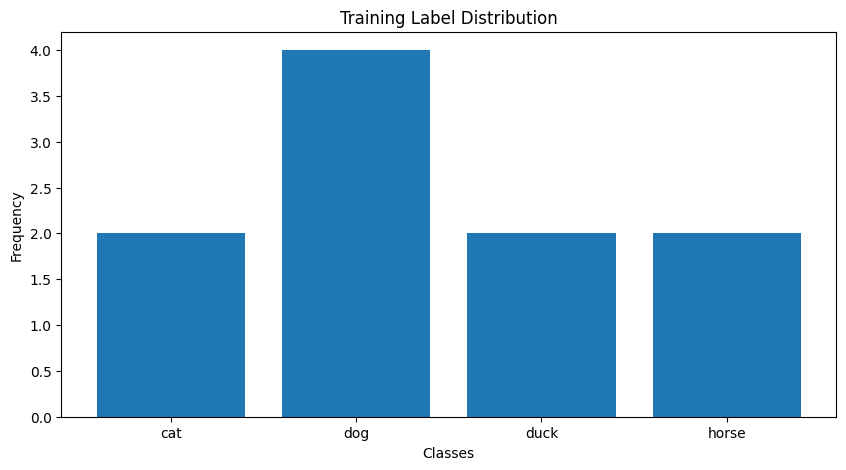

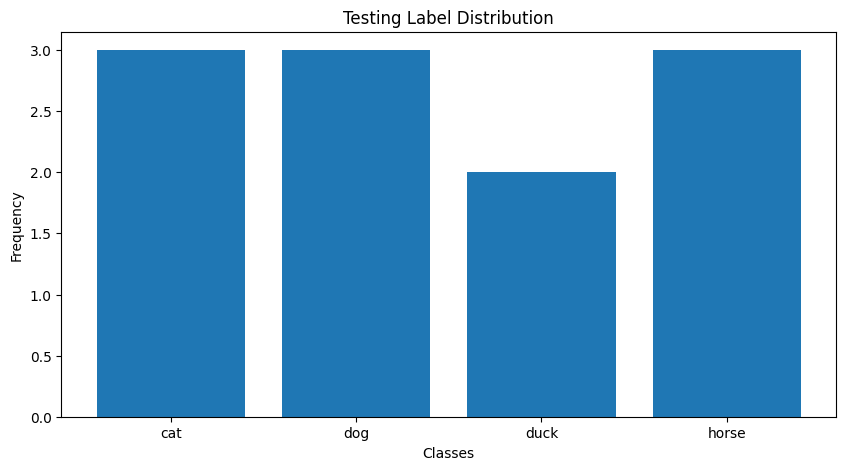

In [18]:
if __name__ == '__main__':
    main()